Generate my own data $x_i \sim \mbox{Gamma}(\alpha=1.5, \beta=60)$ and check that my method recover this. Use fairly few samples, and use only one term in $\alpha$ and $\beta$ polynomials. No need to transform from $\ell \to x$, we generate in $x$ directly

In [1]:
import Distributions, LaTeXStrings,optim, Plots, PyCall, Replica

In [2]:
font = Plots.font("TeX Gyre Heros")
myfonts = Dict(:guidefont=>font,
:xtickfont=>font, :ytickfont=>font, :legendfont=>font);
Plots.pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)

Plots.PyPlotBackend()

In [58]:
α0 = 1.5; β0 = 60
νmin=1.00677
νmax=1.0383018

1.0383018

In [59]:
dist0 = Distributions.Gamma(α0, β0)
Plots.histogram(rand(dist0, 1000))

LoadError: LoadError: error compiling rand: error compiling _rand!: could not load library "libRmath-julia"
libRmath-julia.so: cannot open shared object file: No such file or directory
while loading In[59], in expression starting on line 2

Do we need to make up frequencies? Not really, we just care about one bin, but for compatibility, we do

In [60]:
# define order of linear models
αOrder = 1
βOrder = 1
npackets=2000

# read in data from tardis and create posterior
dim = αOrder + βOrder
∇res, Hres = optim.allocations(dim)
frame, (P, ∇P!, HP!) = optim.problem(αOrder=αOrder, βOrder=βOrder, run=99, npackets=npackets);

# now change the energies
PyCall.@pyimport numpy.random as nprand
nprand.seed(138)
PyCall.@pyimport scipy.stats as stats
dist0 = stats.gamma(α0, scale=1/β0)
# crucial: change frame in place, else optimization runs with old energies!
frame[:energies][:] = dist0[:rvs](size=length(frame[:energies]))
# Plots.histogram(frame[:energies])

# the observed number of packets in the bin
nmin=searchsortedfirst(frame[:nus], νmin)
nmax=searchsortedlast(frame[:nus], νmax)
n = nmax - nmin + 1
x = sum(frame[:energies][nmin:nmax])

# for testing
# n = 291
# x= 7.389999302674019

0.6314524897495356

In [61]:
# compute the posterior mode to estimate the evidence
# start optimization at true values
@time maxP, posterior_mode, ret = optim.run_nlopt(frame, P, ∇P!, HP!,
    αOrder, βOrder, xtol_rel=1e-8, init=1.001*[α0, β0])
HP!(posterior_mode, Hres)
evidence = optim.laplace(maxP, Hres)
println("got $maxP at $(posterior_mode) (returned $ret) and evidence $evidence")

  0.332711 seconds (9.72 M allocations: 148.306 MB, 5.85% gc time)
got 4129.358730514852 at [1.57222,64.206] (returned XTOL_REACHED) and evidence 4128.531888369906


The mode matches the input values well

In [62]:
# the posterior mean with the normalized posterior
# predict at bin center
# ν, X, N
pm = optim.PosteriorMean((νmax + νmin)/2, x, convert(Float64, n))
Pmean, ∇Pmean!, HPmean! = optim.targetfactory(frame, αOrder, βOrder, evidence=evidence, pm=pm)
@time maxPmean, mean_mode, ret = optim.run_nlopt(frame, Pmean, ∇Pmean!, HPmean!, αOrder, βOrder,
init=posterior_mode, xtol_rel=1e-6)
println("max of normalized posterior = $maxPmean at $(mean_mode), returned $ret")

# n, a
nb = optim.NegBinom(n, 1.);

  0.214584 seconds (5.96 M allocations: 91.020 MB, 5.45% gc time)
max of normalized posterior = 0.5409256484643237 at [1.57043,63.8467], returned XTOL_REACHED


The **mode comes out pretty much at the input values** but the normalization seems off, it is very small but should be close to zero

In [75]:
# compute points from quantiles of Gamma
points = collect(linspace(max(x-4, 0.0), x+1, 25))
distn = stats.gamma(n*α0, scale=1/β0)
# points = collect(linspace(distn[:ppf](1e-6), dist0[:ppf](1-1e-6), 25))
results = zeros(points)
# skip X = 0, start at 2
for i in 2:length(points)
    pm.X = points[i]
    results[i] = optim.predict_small(frame, Pmean, ∇Pmean!, HPmean!, pm, αOrder, βOrder, posterior_mode,
    nb, optimize=false)
end

initial N=5
initial N=8
initial N=11
initial N=13
initial N=15
initial N=18
initial N=20
initial N=22
initial N=24
initial N=26
initial N=28
initial N=30
initial N=32
initial N=34
initial N=36
initial N=37
initial N=39
initial N=41
initial N=43
initial N=45
initial N=47
initial N=49
initial N=51
initial N=52


norm = 0.9896660303715538
[0.0,0.0382257,0.267402,0.806557,1.52846,2.12888,2.37427,2.22993,1.83763,1.35083,0.904906,0.563298,0.326132,0.178319,0.092353,0.0457798,0.0217632,0.00994207,0.00438859,0.00188302,0.000783312,0.000317365,0.000125887,4.86965e-5,1.84462e-5]



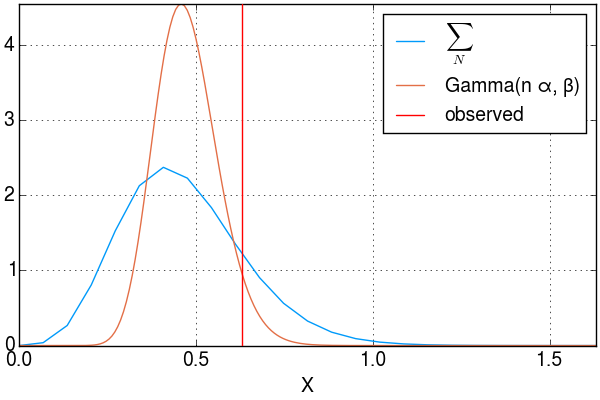

In [76]:
using LaTeXStrings
# self-normalize estimates through Simpson's rule
PyCall.@pyimport scipy.integrate as si
normalization = si.simps(results, points)
println("norm = $normalization")
results /= normalization
println(results)

Plots.plot(points, results, xlabel="X", label=L"\sum_N")
finepoints = collect(linspace(points[1], points[end], 200))
Plots.plot!(finepoints, distn[:pdf](finepoints), label="Gamma(n α, β)")
Plots.vline!([x], line=:red, label="observed")

If we use only 1000 instead of 10000 samples, prediction nearly identical $\Rightarrow$ broadening is due to the Poisson term

In [50]:
using Optim

In [51]:
optimize(x->-P(x), 1.05*[α0, β0], BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [1.5750000000000002,63.0]
 * Minimizer: [1.572218407451092,64.20608193369826]
 * Minimum: -4.129359e+03
 * Iterations: 6
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 27
 * Gradient Calls: 27